In [1]:
import os
import glob
import numpy as np
import pandas as pd

from decimal import *

getcontext().prec = 33

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['legend.frameon']=False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif']=['Helvetica']
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['patch.linewidth'] = 1
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize']=(12,10)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

from scipy.stats import lognorm
from scipy.constants import pi, g, gas_constant
from scipy.optimize import least_squares
from scipy.optimize import differential_evolution
from scipy.linalg import svd

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# read file contents into a dataframe

In [2]:
def readFileContents(filenames:str):
    """
    reads file contents into a pandas data frame
    """
    class_dict = {}
    for fname in filenames:
        # remove path from file name
        _, f = os.path.split(fname)
            
        # remove file extension from file name obtained above
        key, _ = os.path.splitext(f)
            
        # read file contents into a data frame
        df = pd.read_csv(fname, delimiter='\t')
        
        # bin data into different size groups
        class_dict[key] = createClasses(df)
        
    return class_dict

# create bubble classes

In [3]:
def createClasses(df):
    """
    Categorizes bubbles into size classes
    
    args:
        df: pandas dataframe containing the dataset
        
    return:
        arr: numpy array containing class averages
    """
    rows = len(df)
    
    minChord = 0.0
    maxChord = 3.0
    chordIncrement = 0.2
    
    nClasses = int(round((maxChord - minChord)/chordIncrement + 1))
    count = np.zeros(nClasses)
    cbr_num = np.zeros(nClasses)
    ubr_num = np.zeros(nClasses)
    for i in range(rows):
        cbri = df['Chord(mm)'][i]
        ubri = df['Velocity(m/s)'][i]
        for j in range(nClasses):
            lowerEnd = minChord + j*chordIncrement 
            upperEnd = minChord + (j+1)*chordIncrement
            if(cbri > lowerEnd and cbri < upperEnd):
                count[j] = count[j] + 1
                cbr_num[j] = cbr_num[j] + cbri
                ubr_num[j] = ubr_num[j] + ubri
                
    classes = np.zeros((nClasses, 3))
    
    for k in range(nClasses):
        classes[k,0] = cbr_num[k]/count[k]
        classes[k,1] = ubr_num[k]/count[k]
        classes[k,2] = count[k]
    
    return classes

# radially average bubble properties

In [4]:
def radialAverage(class_dict, P, eg_real, eg_folder, UL, rhog, rhol, mul, sigma):
    R = 0.50*0.1016
    rR = ['-0.80', '-0.60', '-0.40', '-0.20', '0', '0.20', '0.40', '0.60', '0.80']
    
    A0 = 0.50*pi*(R**2 - (-0.80*R)**2)
    A1 = 0.50*pi*((-0.80*R)**2 - (-0.60*R)**2)
    A2 = 0.50*pi*((-0.60*R)**2 - (-0.40*R)**2)
    A3 = 0.50*pi*((-0.40*R)**2 - (-0.20*R)**2)
    A4 = pi*((-0.20*R)**2 - (0.00*R)**2)
    A5 = A3
    A6 = A2
    A7 = A1
    A8 = A0
    
    A = [A0, A1, A2, A3, A4, A5, A6, A7, A8]
    
    Cbnums = np.zeros(14)
    Cbdens = np.zeros(14)
    Ubnums = np.zeros(14)
    Ubdens = np.zeros(14)
    
    for i in range(9):
        key = 'P' + str(P) + '-eG' + str(eg_folder) + '-rR' + rR[i]
        arr = class_dict[key]
        for j in range(14):
            Cbnums[j] = Cbnums[j] + (arr[j,0]**3.0)*arr[j,2]*A[i]
            Cbdens[j] = Cbdens[j] + arr[j,2]*A[i]
            Ubnums[j] = Ubnums[j] + arr[j,1]*(arr[j,0]**3.0)*arr[j,2]*A[i]
            Ubdens[j] = Ubdens[j] + (arr[j,0]**3.0)*arr[j,2]*A[i]
    
    results = np.zeros([14,3])
    for k in range(14):
        Ubi = Ubnums[k]/Ubdens[k]
        Usi = Ubi - UL/(1.0 - eg_real)
        results[k,1] = Usi
        
        Cbi = (Cbnums[k]/Cbdens[k])**(1.0/3.0)
        dbi = convertChordToDiameter(Cbi, Usi, rhog, rhol, mul, sigma)
        results[k,0] = dbi
        
        Re = (rhol*Usi*0.001*dbi)/mul
        Eo = (g*(rhol - rhog)*(0.001*dbi)**2.0)/sigma
        E = 1.0/((1.0 + 0.45*Re*Eo)**0.08)
        Cdi = (4.0/3.0)*(rhol-rhog)/rhol*(g*(0.001*dbi)*E**(2.0/3.0))/(Usi**2.0)
        results[k,2] = Cdi

    return results

# convert bubble chord length to diameter

In [5]:
def convertChordToDiameter(cbi, usi, rhog, rhol, mul, sigma):
    """
    converts bubble chord length to volume equivalent diameter
    
    args:
        cbi: bubble chord length
        usi: bubble slip velocity
        rhog: gas density
        rhol: liquid density
        mul: liquid viscosity
        sigma: surface tension
        
    returns:
        dbi: volume equivalent spherical diameter
    """
    Re = (rhol*usi*0.0015*cbi)/mul
    Eo = ((rhol - rhog)*g*(0.0015*cbi)**2)/sigma
    E = 1.0/((1.0 + 0.45*Re*Eo)**0.08)
    
    dbi = 3.0/2.0*cbi*E**(-2.0/3.0)
    
    relError = 1.0
    relTol = 1.0e-8
    
    while(relError > relTol):
        dbi_prev = dbi
        Re = (rhol*usi*0.001*dbi_prev)/mul
        Eo = ((rhol - rhog)*g*(0.001*dbi_prev)**2)/sigma
        E = 1.0/((1.0 + 0.45*Re*Eo)**0.08)
        dbi = 3.0/2.0*cbi*E**(-2.0/3.0)
        relError = abs((dbi - dbi_prev)/dbi)
        
    return dbi

# compute drag coefficient

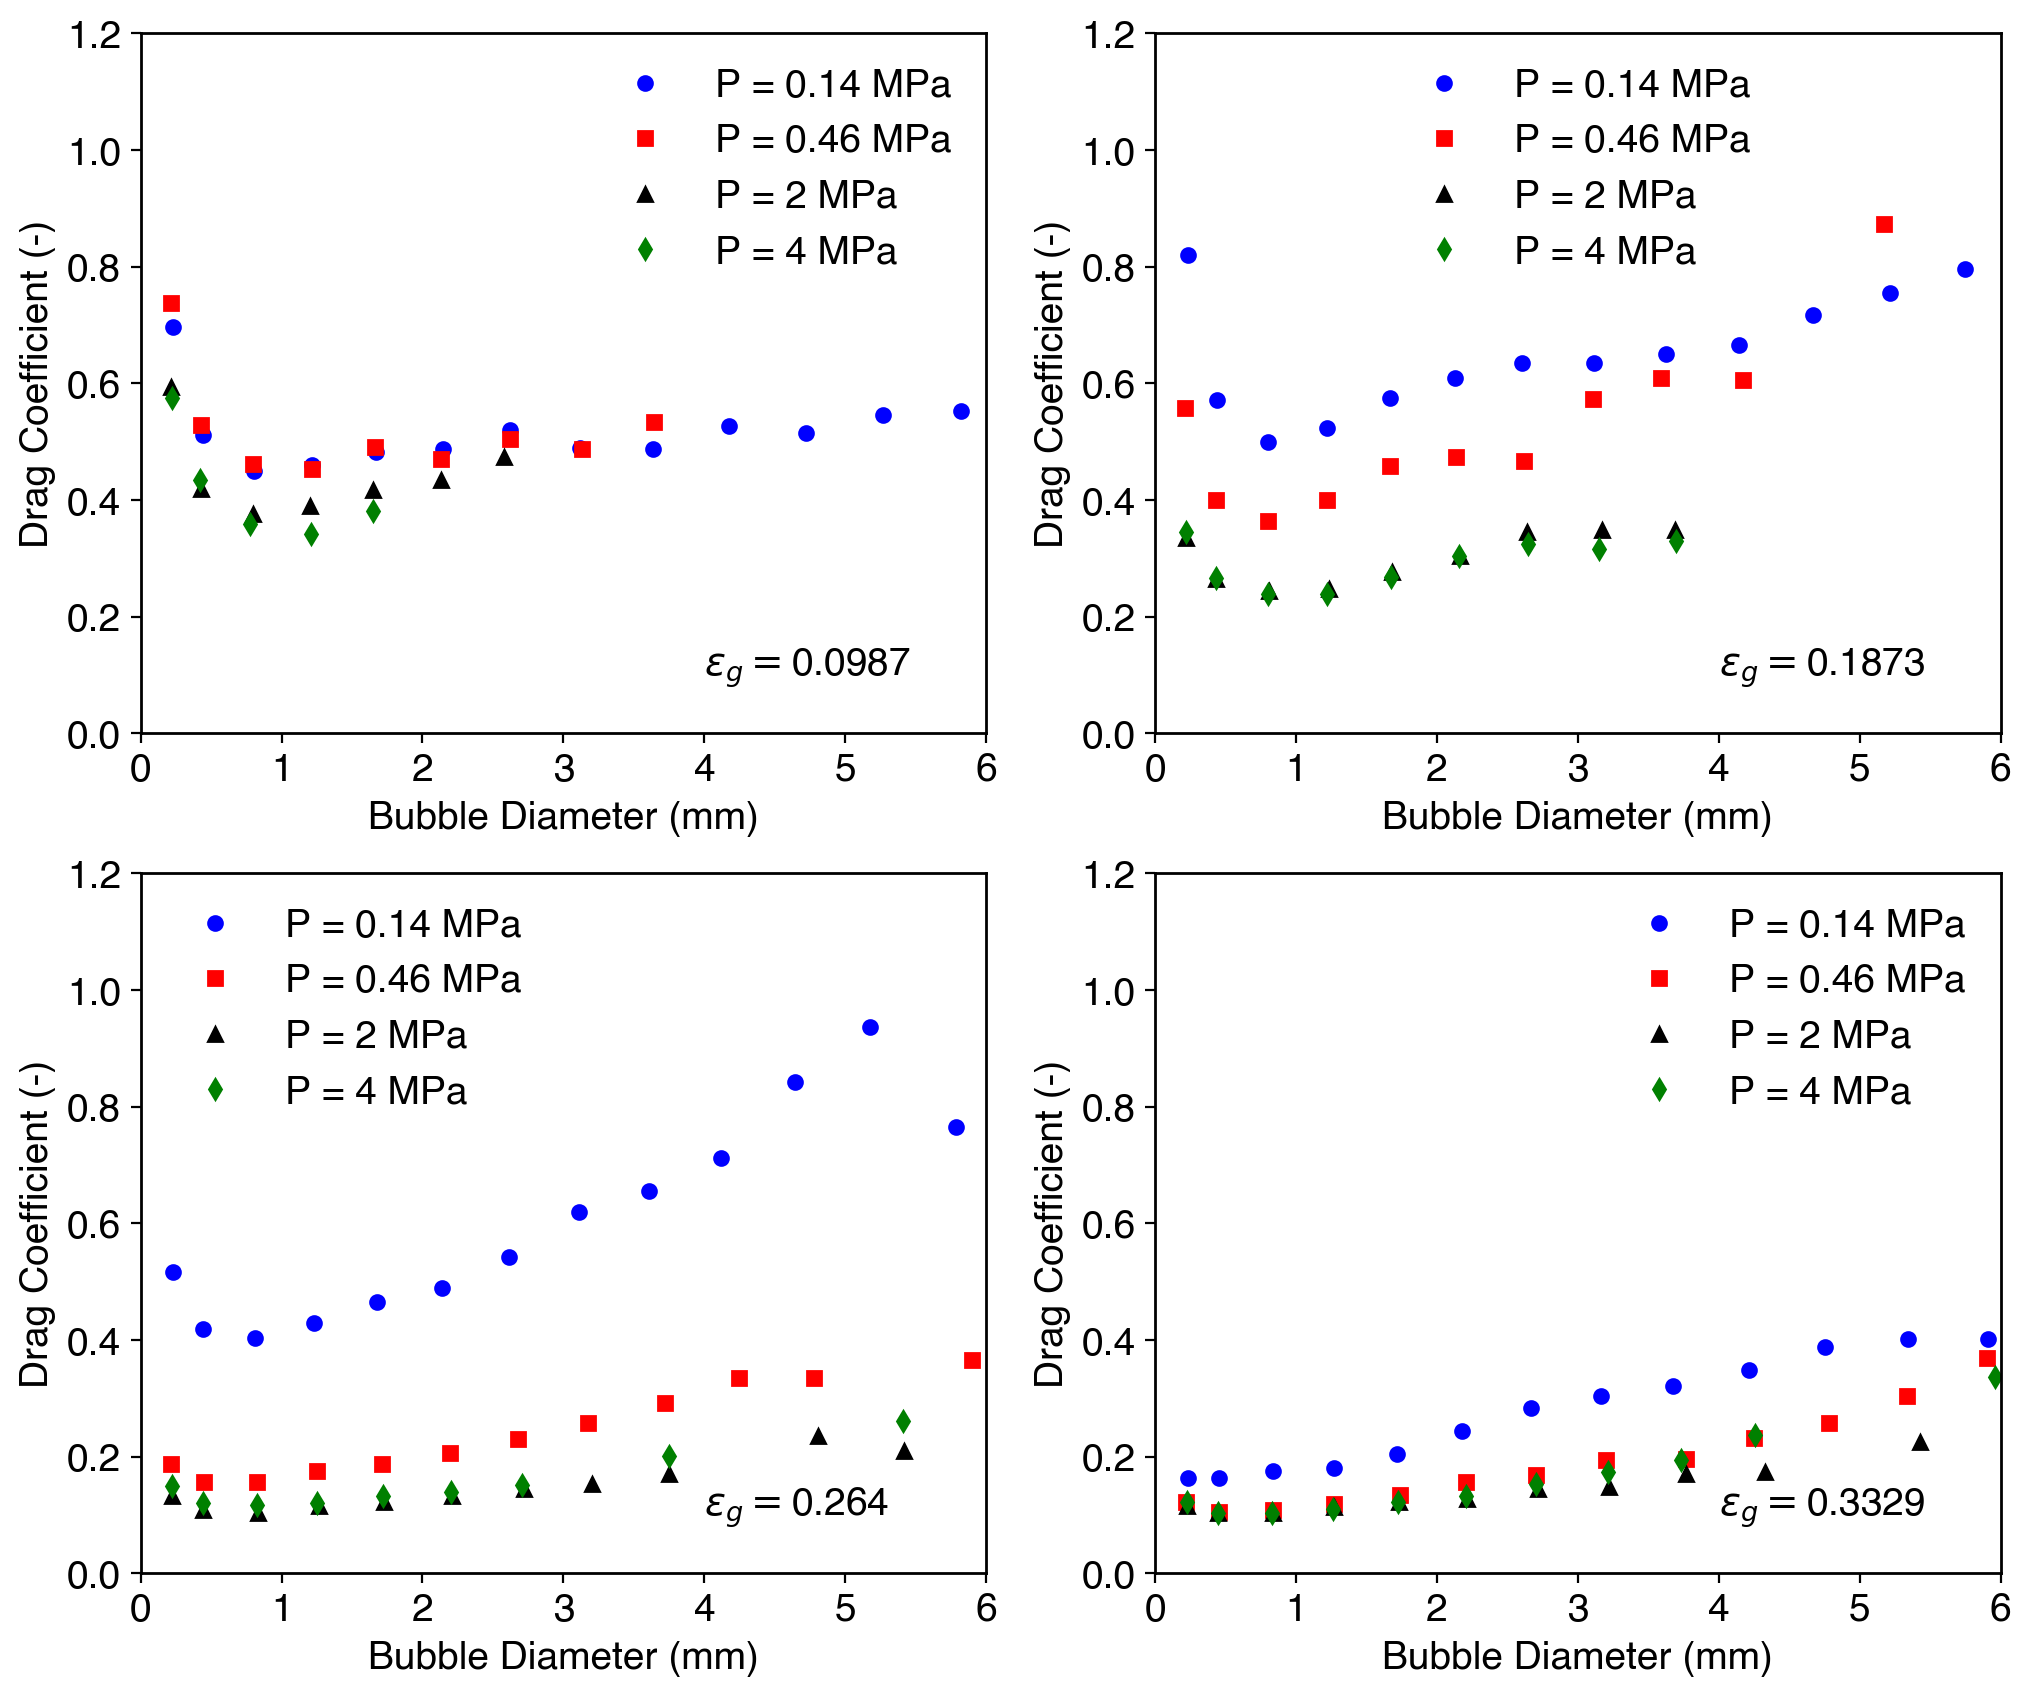

In [6]:
# current working directory
main_dir = os.getcwd()

# actual gas holdups
eg_real = [0.092, 0.102, 0.098, 0.104, 
           0.178, 0.190, 0.187, 0.194,
           0.271, 0.242, 0.264, 0.279, 
           0.335, 0.324, 0.331, 0.342]

# For locating gas holdup folders (mean values)
eg_folder = [0.0987, 0.1873, 0.264, 0.3329]

# actual operating pressures (MPa)
# first row for the lowest mean gas holdup
# last row for the highest mean gas holdup
p_real = [0.14, 0.43, 2.0, 4.2,
          0.14, 0.46, 2.0, 4.0, 
          0.14, 0.46, 2.1, 3.9,
          0.14, 0.48, 2.1, 3.8]

# For locating pressure folders (mean values)
p_folder = [0.14, 0.46, 2, 4]

# actual operating temperatures (K)
# first row for the lowest mean gas holdup
# last row for the highest mean gas holdup
Temp = [300.45, 300.235, 301.290, 303.340, 
        300.96, 300.29, 302.20, 303.853, 
        301.50, 300.66, 302.93, 304.137, 
        301.63, 299.543, 303.340, 304.608]

# liquid density
rhol = 998.0

# liquid viscosity
mul = 0.000935

# surface tension
sigma = 0.068

# liquid superficial velocity (m/s)
UL = 0.030

# dictionary for storing bubble classes at each radial position
bins = {}

# pandas data frame for storing radially averaged data for external plotting
drag_data = pd.DataFrame(data=None)

# list and dictionary for storing modelling data
m_data = []
mdict = {}

# Initiate plotting
markers = ['bo', 'rs', 'k^', 'gd']
for i in range(len(eg_folder)):
    plt.subplot(2,2,i+1)
    for j in range(len(p_folder)):
        # actual gas holdup
        eg = eg_real[4*i + j]
        
        # actual temperature
        T = Temp[4*i + j]
        
        # actual pressure
        p = p_real[4*i + j]
        
        # gas density
        rhog = (p*1e6*0.028)/(gas_constant*T)
        
        # path to files
        path_to_files = main_dir + '/P = ' + str(p_folder[j]) + ' MPa/eG = ' + str(eg_folder[i])
        
        # obtain names of files in the directory specified above
        file_names = glob.glob(os.path.join(path_to_files, '*.txt'))
        
        # read file contents and bin the data
        bins = readFileContents(file_names)
        
        # radially average local bubble properties
        # also compute individual drag coefficients
        global_averages = radialAverage(bins, p_folder[j], eg, eg_folder[i], UL, rhog, rhol, mul, sigma)
        
        # plot global data
        plt.plot(global_averages[:,0], global_averages[:,2], markers[j], ms=5, label = 'P = ' + str(p_folder[j]) + ' MPa')
        
        # store radially averaged data for external plotting
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-dbi'] = global_averages[:,0]
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-Usi'] = global_averages[:,1]
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-Cdi'] = global_averages[:,2]
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-pPrime']=(p/0.10)*np.ones(14)
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-eg'] = eg*np.ones(14)
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-Re'] = (rhol*global_averages[:,1]*0.001*global_averages[:,0])/0.000935
        drag_data['P'+str(int(1000*p_folder[j]))+'-eG'+str(int(10000*eg_folder[i]))+'-Eo'] = ((rhol - rhog)*g*((0.001*global_averages[:,0])**2.0))/sigma
    
        # modelling data  
        Re = (rhol*global_averages[:,1]*0.001*global_averages[:,0])/0.000935
        Eo = ((rhol - rhog)*g*((0.001*global_averages[:,0])**2.0))/sigma
        pNorm = p/(0.1*Eo)
        mdict['Re'] = Re
        mdict['Eo'] = Eo
        mdict['eg'] = eg*np.ones(14)
        mdict['p_norm'] = pNorm
        mdict['Cdi'] = global_averages[:,2]
        mdf = pd.DataFrame(mdict)
        m_data.append(mdf)
        
    # plotting 
    plt.xlabel('Bubble Diameter (mm)')
    plt.ylabel('Drag Coefficient (-)')
    plt.xlim([0,6])
    plt.ylim([0,1.2])
    plt.text(4,0.1,r'$\varepsilon_g = $'+str(eg_folder[i]))
    plt.legend()
plt.show()

# export all data to text files
model_data = pd.concat(m_data, ignore_index=True)
#model_data.to_csv('pnorm2-model_data.txt', sep='\t', index=False, na_rep='nan')
#drag_data.to_csv('pnorm2-drag_data.txt', sep='\t', index=False, na_rep='nan')

# bubble size distribution

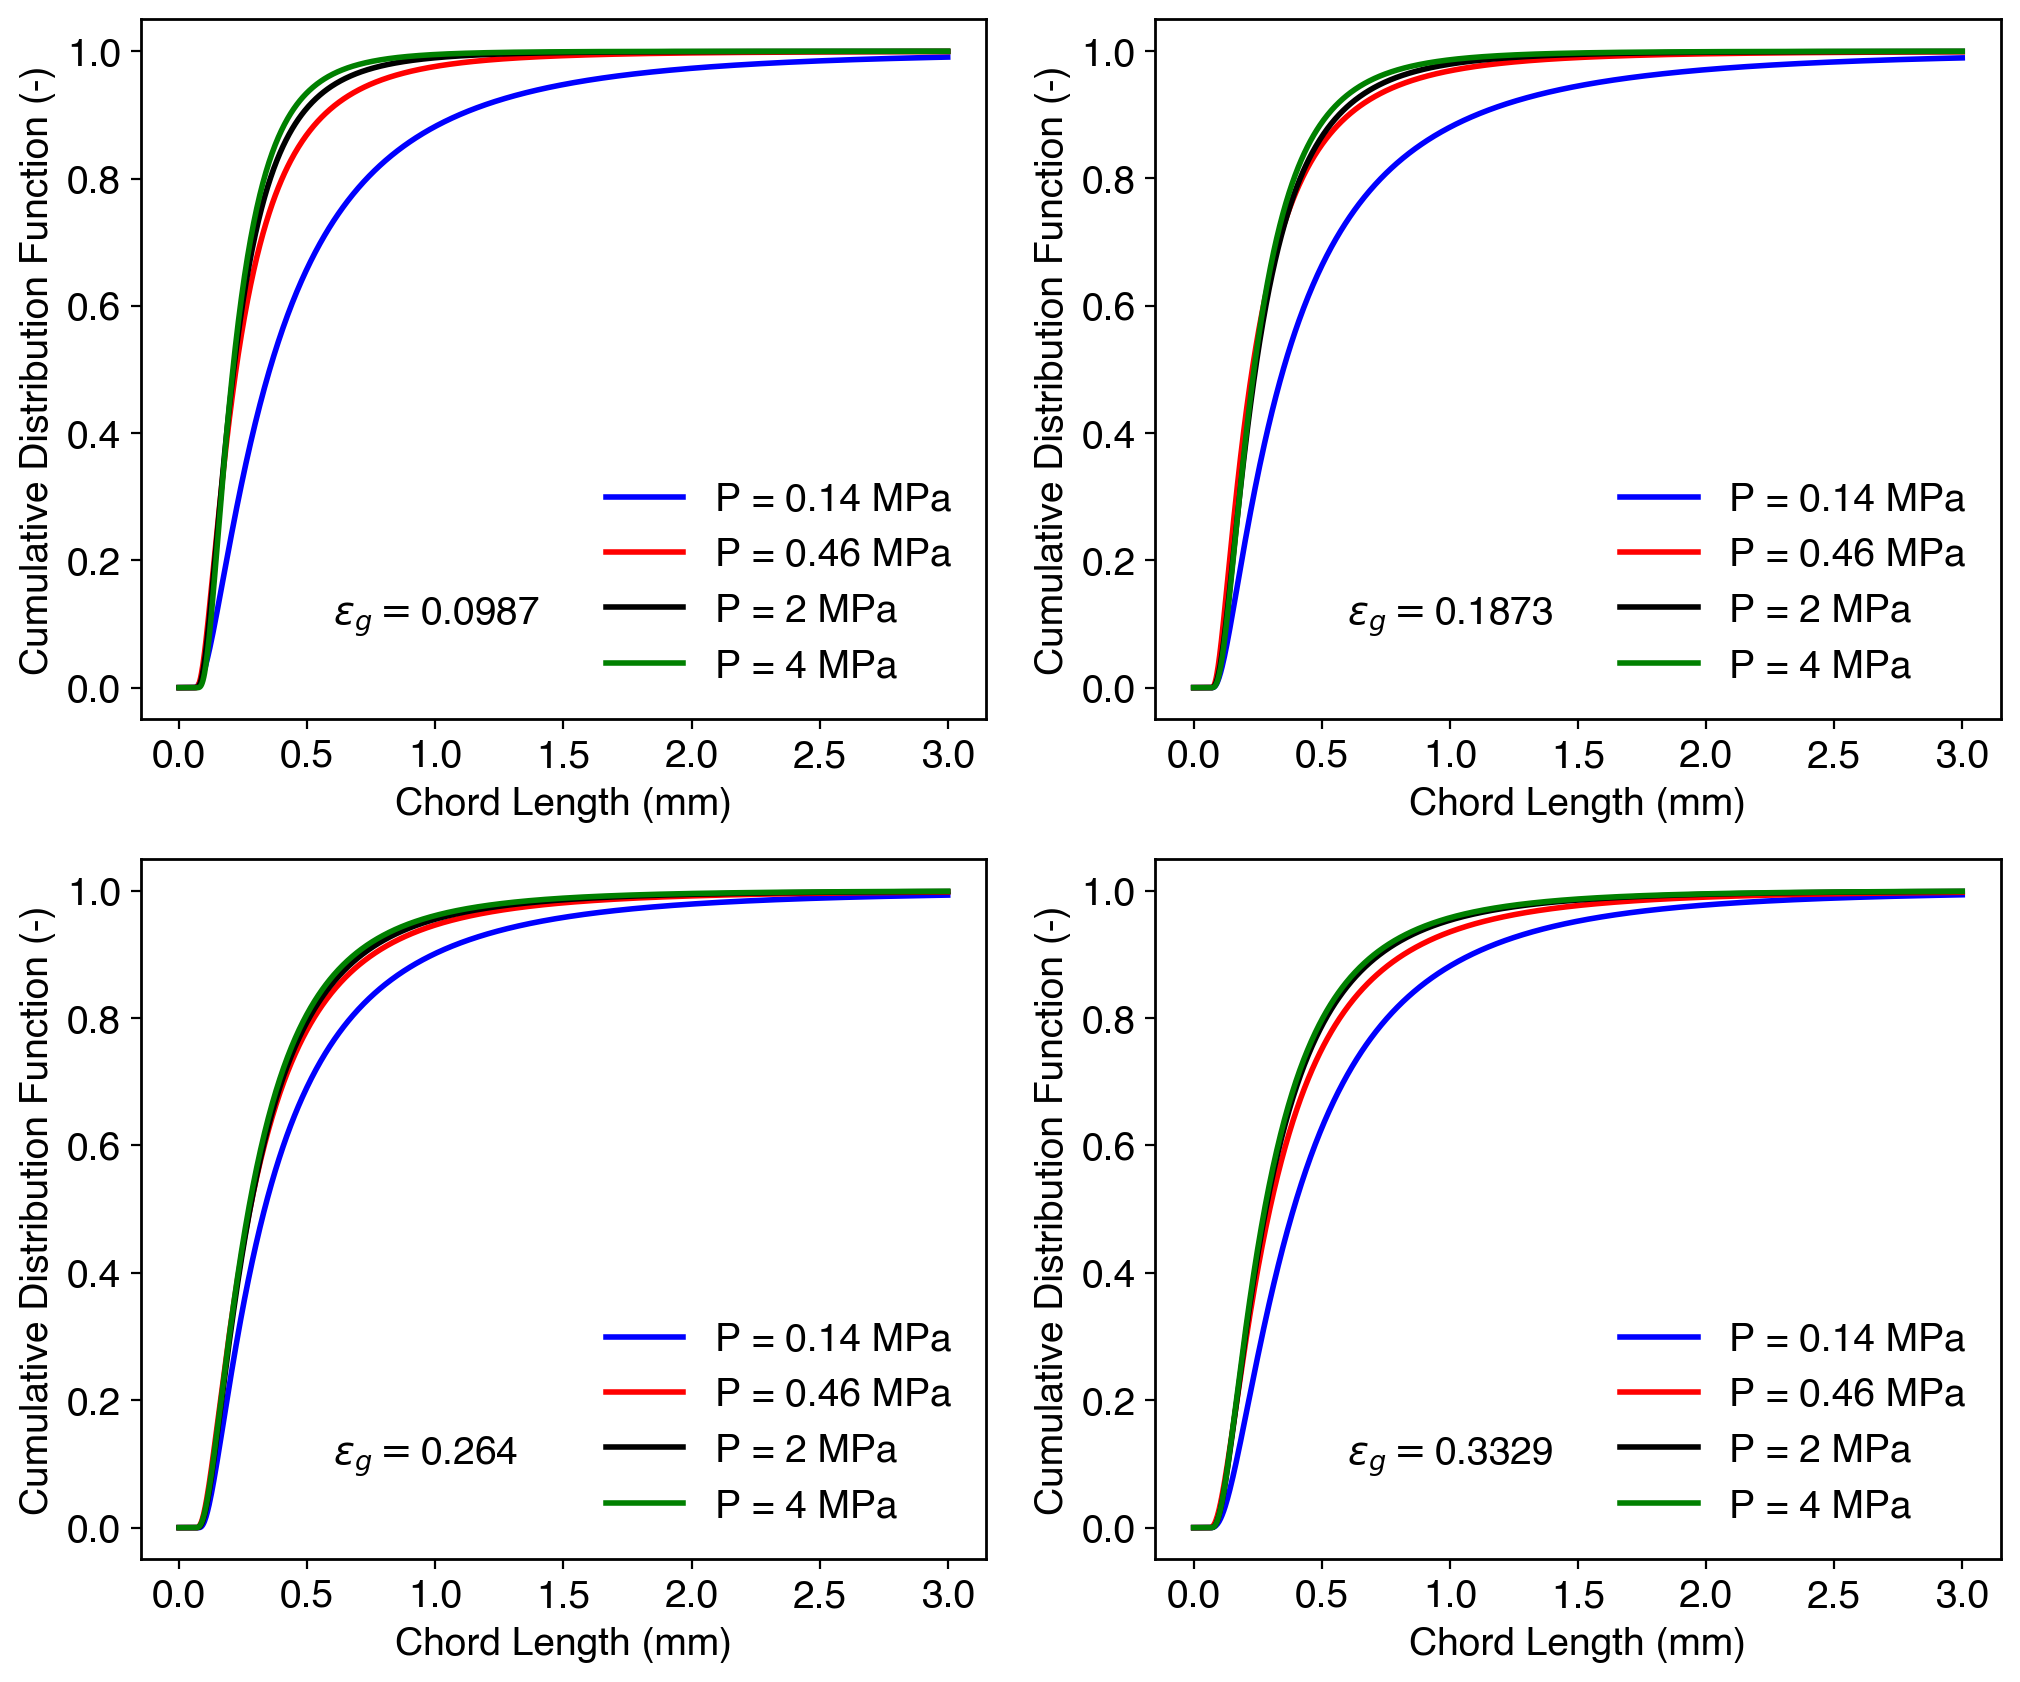

In [7]:
# chord lengths for plotting cumulative distribution function
chords = np.linspace(0, 3, 1000)

# data frame for storing cumulative distribution functions
df_plot = pd.DataFrame(chords, columns=['Chord'])

# plotting
plt.figure(figsize= [12, 10])
lstyles = ['solid', 'solid', 'solid', 'solid']
lcolors = ['blue', 'red', 'black', 'green']

# loop counters
i = 0
for eg in eg_folder:
    plt.subplot(2,2, i+1)
    j=0
    for p in p_folder:
        path_to_files = main_dir + '/P = ' + str(p) + ' MPa' + '/eG = ' + str(eg)
        files = sorted(glob.glob(os.path.join(path_to_files,'*.txt')))
        list_df = []
        for file in files:
            list_df.append(pd.read_csv(file, delimiter='\t'))
        df = pd.concat(list_df)
        shape, loc, scale = lognorm.fit(df['Chord(mm)'])
        cdf = lognorm.cdf(chords, shape, loc, scale)
        pdf = lognorm.pdf(chords, shape, loc, scale)
        df_plot['cdf-P'+str(int(1000*p))+'-eG' + str(int(10000*eg))] = cdf
        df_plot['pdf-P'+str(int(1000*p))+'-eG' + str(int(10000*eg))] = pdf
        plt.plot(chords,cdf,linestyle=lstyles[j], color=lcolors[j], linewidth=2, alpha=1, label='P = ' + str(p_folder[j]) + ' MPa')
        j = j + 1
    plt.xlabel('Chord Length (mm)')
    plt.ylabel('Cumulative Distribution Function (-)')
    plt.text(0.6,0.1,r'$\varepsilon_g = $'+str(eg_folder[i]))
    plt.legend()
    i = i + 1
plt.show()
#df_plot.to_csv('pnorm2-chord-length-cdf.txt', sep = '\t', index=False)

# model function

In [8]:
def model(beta0, beta1, beta2, Re, Eo, eg, p_norm):
    # single bubble drag coefficient at creeping flow conditions
    logCd0 = np.log(24.0/Re)
    
    # correction for inertial and buoyant effects
    # ReEo represents the relative magnitude of 
    # form and viscous drag
    logfReEo = np.log(1.0 + (Re*Eo)**beta0)
    
    # pressure correction
    m = beta1*(1.0 - np.exp(-beta2*p_norm))
    
    # swarm correction
    logfswarm = m*np.log(1.0 - eg)
    
    # all effect combined
    logCdi = logCd0 + logfReEo + logfswarm
    
    return logCdi

# objective functions

In [9]:
def objfunc(betas, *xydata):
    beta0, beta1, beta2 = betas[0], betas[1], betas[2]
    Re, Eo, eg, p_norm, y = xydata
    yhat = model(beta0, beta1, beta2, Re, Eo, eg, p_norm)
    residual = (y-yhat)
    return residual

In [10]:
def objfunc_differential(betas, *xydata):
    beta0, beta1, beta2 = betas[0], betas[1], betas[2]
    Re, Eo, eg, p_norm, ydata = xydata
    yhat = model(beta0, beta1, beta2, Re, Eo, eg, p_norm)
    ss_residuals = 0.0
    for i in range(len(yhat)):
        ss_residuals = ss_residuals + (yhat[i]-ydata[i])**2
    return ss_residuals

# initial parameter estimation with differential evolution

differential_evolution step 1: f(x)= 440.682
differential_evolution step 2: f(x)= 440.682
differential_evolution step 3: f(x)= 101.004
differential_evolution step 4: f(x)= 40.0063
differential_evolution step 5: f(x)= 26.2944
differential_evolution step 6: f(x)= 26.2944
differential_evolution step 7: f(x)= 18.0413
differential_evolution step 8: f(x)= 18.0413
differential_evolution step 9: f(x)= 18.0413
differential_evolution step 10: f(x)= 18.0413
differential_evolution step 11: f(x)= 18.0413
differential_evolution step 12: f(x)= 18.0413
differential_evolution step 13: f(x)= 18.0413
differential_evolution step 14: f(x)= 18.0413
differential_evolution step 15: f(x)= 18.0413
differential_evolution step 16: f(x)= 18.0413
differential_evolution step 17: f(x)= 18.0413
differential_evolution step 18: f(x)= 18.0413
differential_evolution step 19: f(x)= 17.6444
differential_evolution step 20: f(x)= 17.1814
differential_evolution step 21: f(x)= 16.9952
differential_evolution step 22: f(x)= 16.99

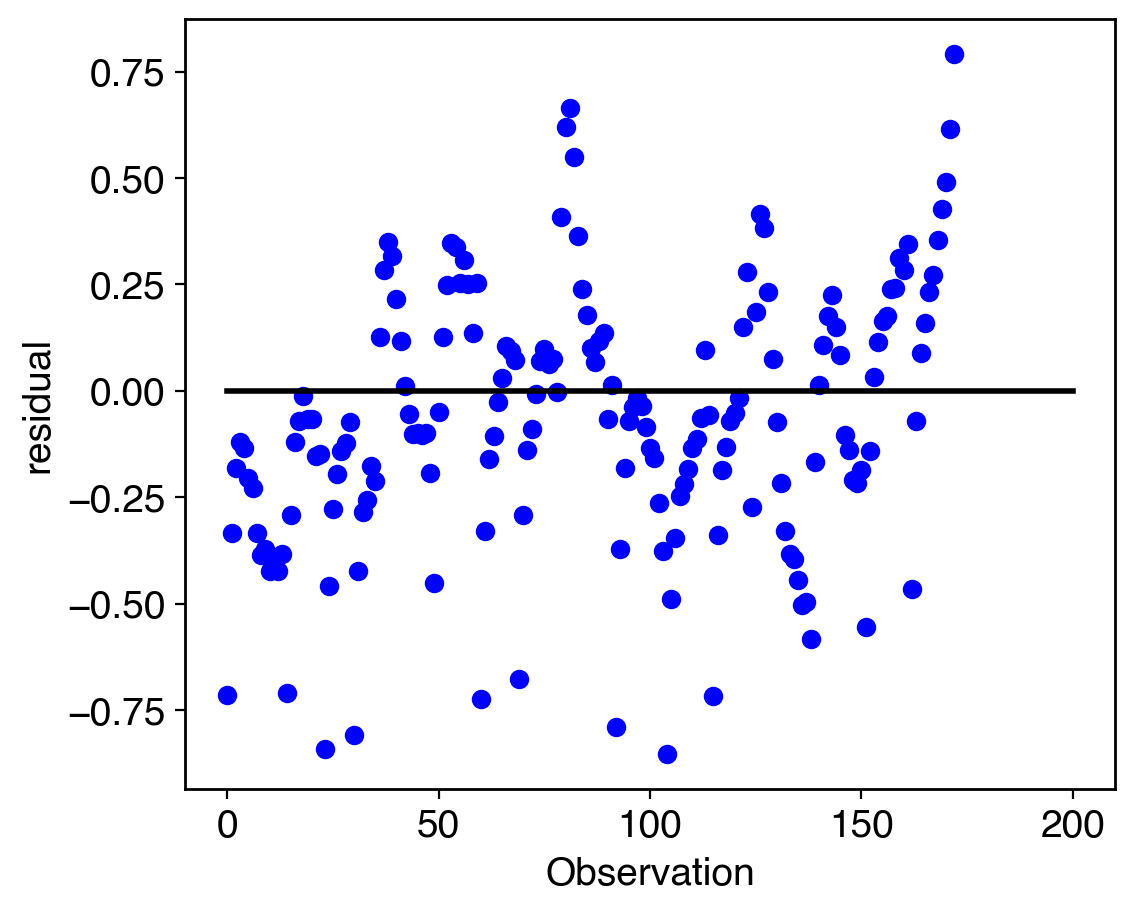

CPU times: user 3.27 s, sys: 115 ms, total: 3.38 s
Wall time: 3.22 s


In [11]:
%%time
# drop rows with missing values
model_data.dropna(inplace=True)
model_data.reset_index(drop=True, inplace=True)

# independent variables
Re = model_data['Re']
Eo = model_data['Eo']
eg = model_data['eg']
p_norm = model_data['p_norm']

# dependent variable
logCdi = np.log(model_data['Cdi'])

# xydata
xydata = (Re, Eo, eg, p_norm, logCdi)

# initial model parameters
betas_ = np.ones(3)

# bounds
bounds = [(-10,10), (-10,10), (-10,10)]

params_de = differential_evolution(objfunc_differential, bounds, args=(xydata), x0=betas_, workers=1, disp=True)
print(params_de)

logCdi_pred = model(params_de.x[0], params_de.x[1], params_de.x[2], Re, Eo, eg, p_norm)

residuals = logCdi - logCdi_pred

plt.rcParams['figure.figsize']=(6,5)

# residual plot
plt.plot(residuals, 'bo')
plt.plot([0,200],[0,0],'k-')
plt.xlabel('Observation')
plt.ylabel('residual')
plt.show()

# final parameter estimation

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.4795e+00                                    4.89e-05    
       1              2         8.4795e+00      2.47e-13       6.23e-08       6.74e-07    
`ftol` termination condition is satisfied.
Function evaluations 2, initial cost 8.4795e+00, final cost 8.4795e+00, first-order optimality 6.74e-07.
beta1 = 0.46 +/- 0.00, beta2 = 3.96 +/- 0.03, beta3 = 0.49 +/- 0.02
R^2 = 0.74


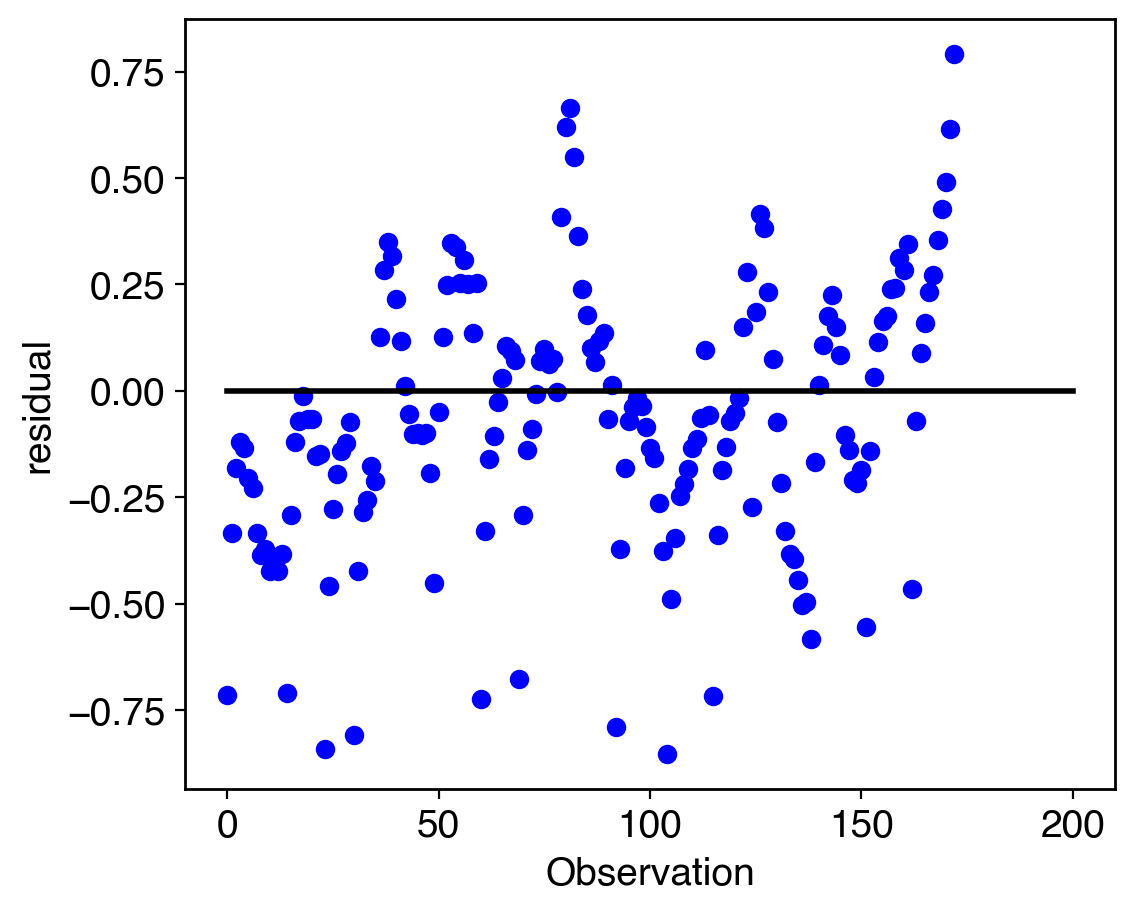

CPU times: user 356 ms, sys: 68.6 ms, total: 425 ms
Wall time: 291 ms


In [12]:
%%time
# parameter estimation
params = least_squares(objfunc, params_de.x, args=(xydata), verbose=2)

# model predictions
logCdi_pred = model(params.x[0], params.x[1], params.x[2], Re, Eo, eg, p_norm)

# estimate R^2
squared_res = (logCdi-logCdi_pred)**2
ssr = np.sum(squared_res)
sst = np.sum((logCdi - np.mean(logCdi))**2)
Rsq = 1.0 - (ssr/sst)

# estimate errors on fitted parameters
U, s, Vh = svd(params.jac, full_matrices=True)
tol = np.finfo(float).eps*s[0]*max(params.jac.shape)
w = s > tol
cov = (Vh[w].T/s[w]**2) @ Vh[w]  
perr = np.sqrt(np.diag(cov))/np.sqrt(len(logCdi)-1)  

print(f'beta1 = {params.x[0]:.2f} +/- {perr[0]:.2f}, beta2 = {params.x[1]:.2f} +/- {perr[1]:.2f}, beta3 = {params.x[2]:.2f} +/- {perr[2]:.2f}')
print(f'R^2 = {Rsq:.2f}')

residuals = logCdi - logCdi_pred

# residual plot
plt.plot(residuals, 'bo')
plt.plot([0,200],[0,0],'k-')
plt.xlabel('Observation')
plt.ylabel('residual')
plt.show()